[Run the notebook](https://colab.research.google.com/drive/1jUb0Q8xL8fYeKEUP1JEh8r9o2u8n3q5S?usp=sharing)

Installing the Transformers and Datasets libraries to run this notebook.



In [2]:
! pip install -q datasets transformers[sentencepiece]

     |████████████████████████████████| 325 kB 10.0 MB/s 
     |████████████████████████████████| 4.0 MB 57.3 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.6 MB/s 
     |████████████████████████████████| 136 kB 67.7 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 127 kB 60.5 MB/s 
     |████████████████████████████████| 144 kB 61.8 MB/s 
     |████████████████████████████████| 271 kB 65.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 895 kB 52.4 MB/s 
     |████████████████████████████████| 596 kB 77.0 MB/s 
     |████████████████████████████████| 6.6 MB 39.9 MB/s 
     |████████████████████████████████| 1.2 MB 49.5 MB/s 


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier([
    "I've been waiting for a HuggingFace course my whole life.", 
    "I hate this so much!"
])

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## Tokenization

Raw Text -> Small chunks called Tokens -> Adding Specical Tokens(if models expects eg- BERT expects) -> Tokenizer matches each token to it's id in the vocabulary of that pre-trained model

In [5]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # SPECIFYING MODEL
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt") # return pytorch tensor"
print(inputs.keys())
print()
print(inputs)
'''
Any sentence larger than maximum model can handel is truncated if `truncation=True`
'''

dict_keys(['input_ids', 'attention_mask'])

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


'\nAny sentence larger than maximum model can handel is truncated if `truncation=True`\n'

## MODEL

In [6]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


`torch.Size([2, 16, 768])`

Tensor has **2** sentences each of **16** **tokens** and indent size of model is **768**.

#### USING AutoModelForXXX

To get output link of the classification problem we will use `AutoModelForSequenceClassification` class it works exactly like `AutoModel` class expect it will give a model with classification head. There is one AutoModel class for each common NLP task in **transformers** library.

In [7]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


After giving model 2 sentences we get a tensor of size 2x2, one result for each sentence and for each possible label. The outputs are not probabilities yet. Each model of transformers library returns **logits**. To understand logits we need *postprocessing* which is last step of pipeline.

## POSTPROCESSING

To covert logits into probabilities softmax layers need to be applied to them. Which will transform them into postive numbers which will sum up to one.

In [8]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [9]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

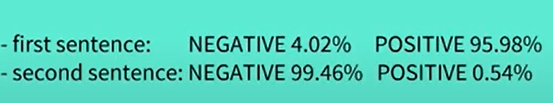